# $\chi^2$ Test

In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt

import imprint as ip
from imprint.models.chisq import ChiSqTest

In this tutorial, we study the $\chi^2$ test under the Gaussian data assumption.
Let $X_1,\ldots, X_n \sim \mathcal{N}(0, \sigma^2)$ be i.i.d. samples
with $\sigma^2$ unknown.
We wish to test the hypothesis that $H_0: \sigma \leq \sigma_0$ for fixed $\sigma_0$.
The $\chi^2$ test constructs the usual variance estimator as the test statistic:
$$
\begin{align*}
    T := \sum\limits_{i=1}^n (X_i - \bar{X})^2
\end{align*}
$$
and rejects the null if $T > t^*$ where $t^* := \sigma_0^2 (\chi^2_{n-1})^{-1}(1-\alpha)$,
i.e. the $1-\alpha$ quantile of $\chi^2_{n-1}$ and scaled by $\sigma_0^2$.
To follow the convention of $\lambda$-indexing, 
we let $\lambda := -t^*$ so that increasing $\lambda$ increases the rejection set.

In the normal family $\{\mathcal{N}(0, \sigma^2) : \sigma \in S\}$ for some set $S$,
the natural parameter is
$$
\begin{align*}
    \theta(\sigma) := -\frac{1}{2\sigma^2}
\end{align*}
$$
Letting $\theta_0 := \theta(\sigma_0)$, the null hypothesis is then
$H_0: \theta \leq \theta_0$.

In [2]:
alpha = 0.025  # target nominal level
sigma_0 = 2  # fixed boundary of null hypothesis
n_samples = 10  # number of samples
n_gridpts = 100  # number of grid-points
n_sims = 2**13  # number of simulations
theta_min = -0.5  # minimum theta in grid
theta_max = -0.5 / (sigma_0**2)  # maximum theta in grid
lam = -(sigma_0**2) * scipy.stats.chi2.isf(
    alpha, df=n_samples - 1
)  # critical threshold

The model can be expressed in many ways and we show that both methods will result in similar bounds.
As described above, the data can be seen as being drawn from a normal family.
However, since the test only depends on $T$, which is known to be distributed $\sigma^2 \chi^2_{n-1}$,
we can also view the model as having a single draw of a $\sigma^2 \chi^2_{n-1}$ random variable.
This distinction changes the `family` type of the model,
which will ultimately decide how the Tilt-Bound should be constructed.
In this case, `chisq` will provide a slightly better bound,
since we are using more assumptions about the model itself,
i.e. the distribution of the test statistic.

## Family `normal2`

By parametrizing the data distribution as `normal2`,
we are treating both the mean and variance parameters as unknown.
Then, we only grid along the variance component and keep the mean parameter fixed at $0$.

In [12]:
# construct theta1 away from -infinity to have a well-defined model.
grid = ip.cartesian_grid(
    theta_min=[0, theta_min],
    theta_max=[0, theta_max],
    n=[1, n_gridpts],
    null_hypos=[ip.hypo(f"x1 <= {theta_max}")],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=100, worker_id=1, t=1674696078, n_bits=18, worker_bits=18) = [4403773729734393856 4403773729734393857 4403773729734393858, ...]:


In [13]:
rej_df = ip.validate(
    ChiSqTest,
    grid,
    lam,
    K=n_sims,
    model_kwargs={"n_samples": n_samples, "family": "normal2"},
)
rej_df.tail()

TypeError: validate() got an unexpected keyword argument 'family'

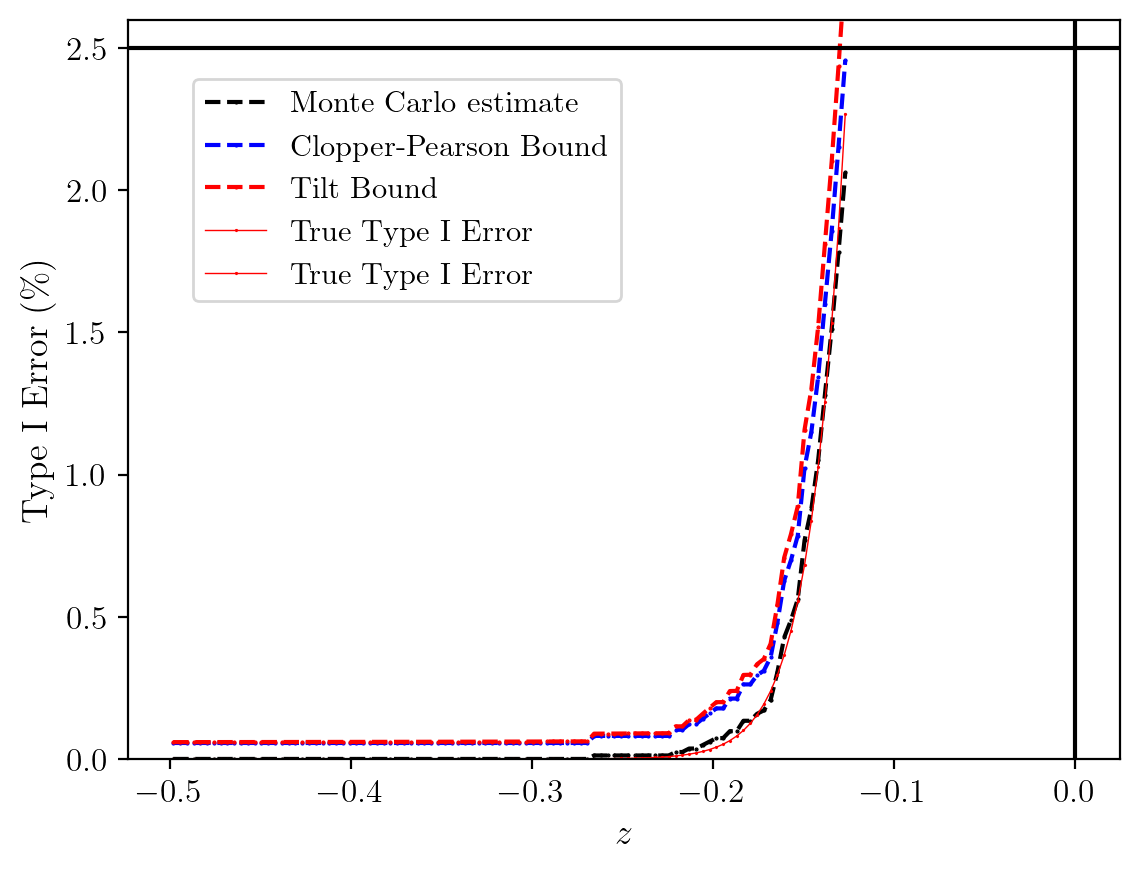

In [14]:
g_rej = grid.add_cols(rej_df)
g_rej.df.sort_values("theta1", inplace=True)
theta = grid.get_theta()
true_err = scipy.stats.chi2.sf(2 * lam * theta, df=n_samples - 1)

plt.plot(
    g_rej.df["theta1"],
    100 * g_rej.df["tie_est"],
    "k--o",
    markersize=0.5,
    label="Monte Carlo estimate",
)
plt.plot(
    g_rej.df["theta1"],
    100 * g_rej.df["tie_cp_bound"],
    "b--o",
    markersize=0.5,
    label="Clopper-Pearson Bound",
)
plt.plot(
    g_rej.df["theta1"],
    100 * g_rej.df["tie_bound"],
    "r--o",
    markersize=0.5,
    label="Tilt Bound",
)
plt.plot(
    g_rej.df["theta1"],
    100 * true_err,
    "r-*",
    linewidth=0.5,
    markersize=0.5,
    label="True Type I Error",
)
plt.axhline(2.5, color="k")
plt.axvline(0, color="k")
plt.ylim([0, 2.6])
plt.legend(fontsize=11, bbox_to_anchor=(0.05, 0.94), loc="upper left")
plt.xlabel("$z$")
plt.ylabel(r"Type I Error (\%)")
plt.show()

## Family `scaled_chisq`

By parametrizing the data distribution as `scaled_chisq`,
we are treating only the variance parameter as unknown.
Then, we only grid along the variance component.

In [15]:
# construct theta1 away from -infinity to have a well-defined model.
grid = ip.cartesian_grid(
    theta_min=[theta_min],
    theta_max=[theta_max],
    n=[n_gridpts],
    null_hypos=[ip.hypo(f"x0 <= {theta_max}")],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=100, worker_id=1, t=1674696090, n_bits=18, worker_bits=18) = [4403774554368114688 4403774554368114689 4403774554368114690, ...]:


In [8]:
rej_df = ip.validate(
    ChiSqTest,
    grid,
    lam,
    K=n_sims,
    model_kwargs={"n_samples": n_samples, "family": "scaled_chisq"},
)
rej_df.tail()

,tie_sum,tie_est,tie_cp_bound,tie_bound
95,86,0.010498,0.013427,0.015193
96,105,0.012817,0.016015,0.018118
97,124,0.015137,0.018580,0.021025
98,146,0.017822,0.021525,0.024367
99,169,0.020630,0.024584,0.027847


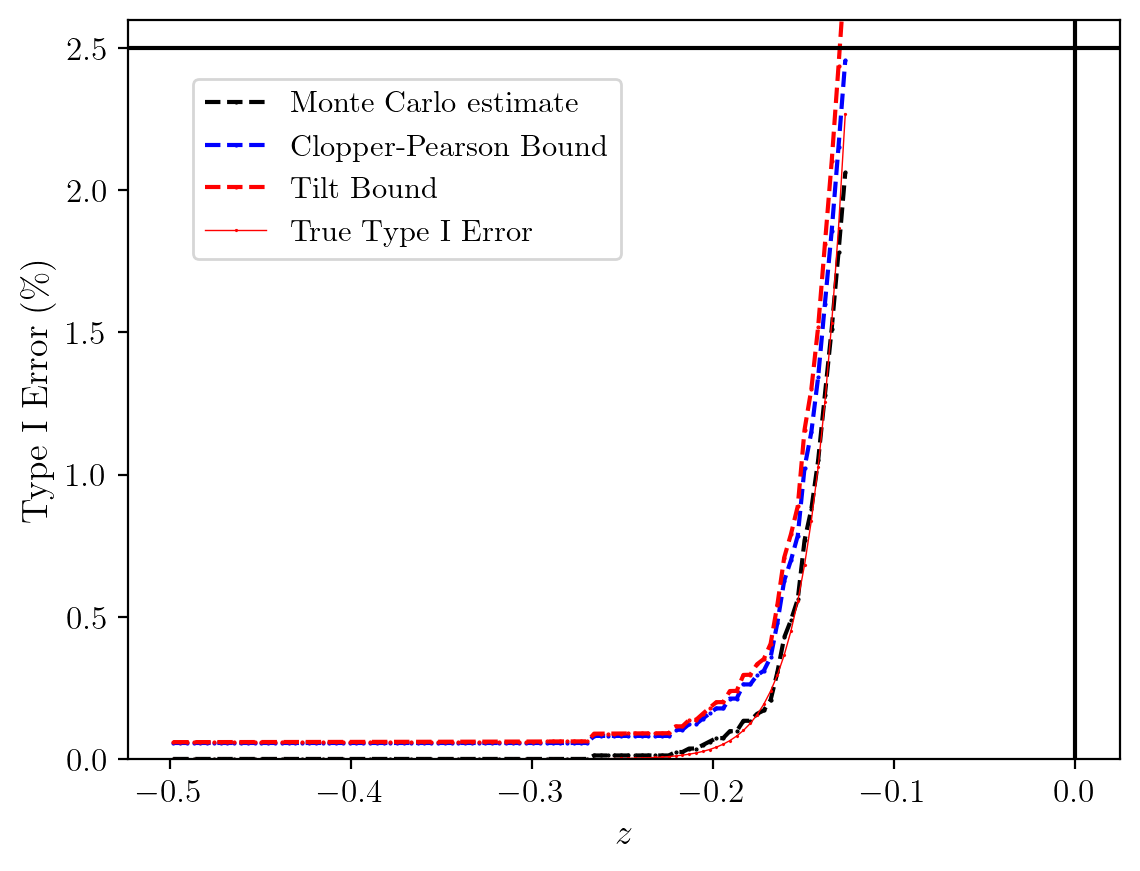

In [10]:
g_rej = grid.add_cols(rej_df)
g_rej.df.sort_values("theta0", inplace=True)
theta = grid.get_theta()
true_err = scipy.stats.chi2.sf(2 * lam * theta, df=n_samples - 1)

plt.plot(
    g_rej.df["theta0"],
    100 * g_rej.df["tie_est"],
    "k--o",
    markersize=0.5,
    label="Monte Carlo estimate",
)
plt.plot(
    g_rej.df["theta0"],
    100 * g_rej.df["tie_cp_bound"],
    "b--o",
    markersize=0.5,
    label="Clopper-Pearson Bound",
)
plt.plot(
    g_rej.df["theta0"],
    100 * g_rej.df["tie_bound"],
    "r--o",
    markersize=0.5,
    label="Tilt Bound",
)
plt.plot(
    g_rej.df["theta0"],
    100 * true_err,
    "r-*",
    linewidth=0.5,
    markersize=0.5,
    label="True Type I Error",
)
plt.axhline(2.5, color="k")
plt.axvline(0, color="k")
plt.ylim([0, 2.6])
plt.legend(fontsize=11, bbox_to_anchor=(0.05, 0.94), loc="upper left")
plt.xlabel("$z$")
plt.ylabel(r"Type I Error (\%)")
plt.show()